In [1]:
import uproot
import awkward as ak
import numpy as np
import math
from tqdm import tqdm
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
import gc
from itertools import product
import sys
sys.path.append('..')  
from Plot import Plot
import ROOT as R

vector.register_awkward() 
DATATYPE="data"
BASEDIR="/pbs/throng/training/nantes-m2-rps-exp/data"
#SAMPLE_RUN = [291694]
SAMPLE_RUN = [291694, 290254, 290427, 290613, 290776, 291002, 291360, 291482, 291755, 292061]
MUON_MASS = 0.105
D_ABS = 500

if DATATYPE=="mc":
    gen_tree = f"{BASEDIR}/run{SAMPLE_RUN}.{DATATYPE}.root:genTree"
IS_MC=True if DATATYPE=="mc" else False
def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
    datatype="mc" if is_mc else "data"
    print({dest},"/run",{run},".",{datatype},".root")
    return f"{dest}/run{run}.{datatype}.root"

In [2]:
def getTracks(events):
    return ak.zip({ "px":events["Muon_Px"],
                    "py":events["Muon_Py"],
                    "pz":events["Muon_Pz"],
                    "E":events["Muon_E"],
                    "DCAx":events["Muon_xDCA"],
                    "DCAy":events["Muon_yDCA"],
                    "DCAz":events["Muon_zDCA"],
                    "charge":events["Muon_Charge"],
                    "thetaAbs":events["Muon_thetaAbs"],
                    "matched":events["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

In [3]:
def applySelection(data, criteria, plot=False, **kwargs):
    selected = data[criteria(data)]
    if plot:
        hist_before = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=20,name='$|p|$'))
        hist_after = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=20,name='$|p|$'))
        try:
            hist_before.fill(ak.flatten(data.pt))
            hist_after.fill(ak.flatten(selected.pt))
        except AttributeError:
            hist_before.fill(ak.flatten(getTracks(data).pt))
            hist_after.fill(ak.flatten(getTracks(selected).pt))
        #Plot(hist_before, hist_after, **kwargs)
    return selected

In [4]:
def get_pDCA_infos(goodTracks):
    DCA=np.sqrt(goodTracks.DCAx**2 + goodTracks.DCAy**2 + goodTracks.DCAz**2)
    p0=ak.where(goodTracks.thetaAbs < 3 , goodTracks.p - 3.0, goodTracks.p - 2.4)
    pDCA=p0*DCA
    
    N=3 #choice of resolution should be a number between 1 and 10
    sigmaAbs=ak.where(goodTracks.thetaAbs < 3, 80.0, 54.0) #factor used due to the crossed materials 
    pRes= 0.0004 * goodTracks.p
    sigmap= sigmaAbs/ (1 - ((N*pRes)/(1 + N*pRes)))

    thetaRes= 0.0005 * goodTracks.p
    sigmatheta= 535 * thetaRes

    #computing total resolution for pDCA
    sigmapDCA=np.sqrt(sigmap**2 + sigmatheta**2)

    goodTracks["pDCA"] = pDCA

    return pDCA, N, sigmapDCA

In [5]:
def analyzeEventsTree():
    events = uproot.concatenate([data_file_path(SAMPLE) for SAMPLE in SAMPLE_RUN])
    
    # Définition des fonctions de sélection
    def select_charge(events):
        charge = []
        for charges in events["Muon_Charge"]:
            if (-1 in charges) and (1 in charges):
                charge += [True]
            else:
                charge += [False]
        return charge
    
    def select_z(events):
        z = events["zVtx"]
        return (z < 10) & (z > -10)
    
    select_nb = lambda events: events["nMuons"] >= 2

    #Sélections pour les events
    events_raw = events
    events_nb = applySelection(events_raw, select_nb)
    events_z = applySelection(events_raw, select_z)
    events_charge = applySelection(events_raw, select_charge)
    
    # Sélections pour les tracks
    select_pt = lambda tracks: tracks.pt > 1
    select_match = lambda tracks: tracks.matched >= 1
    select_eta = lambda tracks: (tracks.eta < -2.5) & (tracks.eta > -4)
    select_Rabs = lambda tracks: (D_ABS * np.abs(np.tan(tracks.thetaAbs * (3.141592/180))) > 17.5) & (D_ABS * np.abs(np.tan(tracks.thetaAbs*(3.141592/180))) < 89.5)

    tracks_raw = getTracks(events_raw)  
    tracks_pt = applySelection(tracks_raw, select_pt)
    tracks_match = applySelection(tracks_raw, select_match)
    tracks_eta = applySelection(tracks_raw, select_eta)
    tracks_Rabs = applySelection(tracks_raw, select_Rabs)

    
    pDCA, N, sigmapDCA = get_pDCA_infos(tracks_raw)
    select_pDCA = lambda tracks: pDCA < N*sigmapDCA
    tracks_pDCA = applySelection(tracks_raw, select_pDCA)

    datasets = {
        "raw": ak.flatten(tracks_raw.pt),                               
        "pt": ak.flatten(tracks_pt.pt),               
        "match": ak.flatten(tracks_match.pt),
        "eta": ak.flatten(tracks_eta.pt),
        "Rabs": ak.flatten(tracks_Rabs.pt),
        "pDCA": ak.flatten(tracks_pDCA.pt),
}
    return datasets



{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291694} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290254} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290427} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290613} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290776} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291002} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291360} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291482} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291755} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {292061} . {'data'} .root


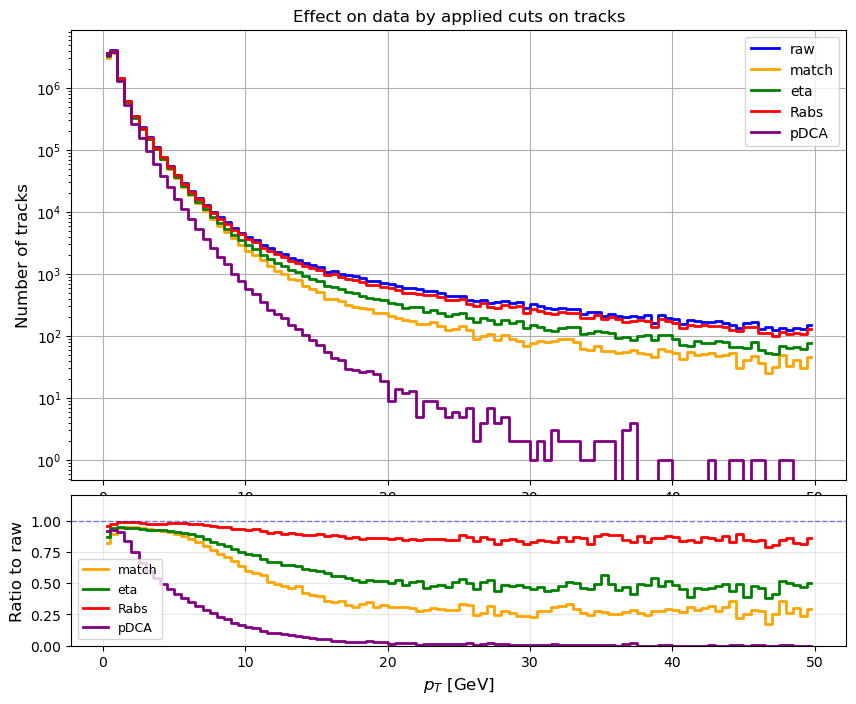

In [6]:
datasets = analyzeEventsTree()

hists = {
    "raw": hist.Hist(hist.axis.Regular(100, 0, 50)),
    #"pt": hist.Hist(hist.axis.Regular(500, 0, 200)),
    "match": hist.Hist(hist.axis.Regular(100, 0, 50)),
    "eta": hist.Hist(hist.axis.Regular(100, 0, 50)),
    "Rabs": hist.Hist(hist.axis.Regular(100, 0, 50)),
    "pDCA": hist.Hist(hist.axis.Regular(100, 0, 50)),
}

for key, h in hists.items():
    h.fill(datasets[key])

colors = ["blue", "orange", "green", "red", "purple"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), 
                                gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})

for i, (key, h) in enumerate(hists.items()):
    ax1.step(h.axes[0].centers, h.values(), where='mid', color=colors[i], label=key, linewidth=2)

ax1.set_ylabel("Number of tracks", fontsize=12)
ax1.set_yscale("log")
ax1.set_title("Effect on data by applied cuts on tracks")
ax1.legend()
ax1.grid(True)
#ax1.tick_params(labelbottom=False)  # Enlever les labels x du plot du haut

h_raw = hists["raw"]
centers = h_raw.axes[0].centers
values_raw = h_raw.values()

for i, (key, h) in enumerate(hists.items()):
    if key != "raw":  #pas tracer le raw/raw
        values_cut = h.values()
        
        #ne pas diviser par zéro
        ratio = np.divide(values_cut, values_raw, 
                         out=np.zeros_like(values_cut, dtype=float), 
                         where=values_raw != 0)
        
        ax2.step(centers, ratio, where='mid', color=colors[i], label=key, linewidth=2)

ax2.set_xlabel(r"$p_T$ [GeV]", fontsize=12)
ax2.set_ylabel("Ratio to raw", fontsize=12)
ax2.axhline(y=1, color='blue', linestyle='--', linewidth=1, alpha=0.5) #ref à 1
ax2.set_ylim([0, 1.2])
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=9)

plt.show()

In [7]:
def analyzeEventsTree2():
    events = uproot.concatenate([data_file_path(SAMPLE) for SAMPLE in SAMPLE_RUN])
    
    # Définition des fonctions de sélection
    def select_charge(events):
        charge = []
        for charges in events["Muon_Charge"]:
            if (-1 in charges) and (1 in charges):
                charge += [True]
            else:
                charge += [False]
        return charge
    
    def select_z(events):
        z = events["zVtx"]
        return (z < 10) & (z > -10)
    
    select_nb = lambda events: events["nMuons"] >= 2

    #Sélections pour les events
    events_raw = events
    events_nb = applySelection(events_raw, select_nb)
    events_z = applySelection(events_raw, select_z)
    events_charge = applySelection(events_raw, select_charge)

    select_pt = lambda tracks: tracks.pt > 1
    select_match = lambda tracks: tracks.matched >= 1
    select_eta = lambda tracks: (tracks.eta < -2.5) & (tracks.eta > -4)
    select_Rabs = lambda tracks: (D_ABS * np.abs(np.tan(tracks.thetaAbs * (3.141592/180))) > 17.5) & (D_ABS * np.abs(np.tan(tracks.thetaAbs*(3.141592/180))) < 89.5)

    tracks_raw = getTracks(events_raw)
    tracks_pt = applySelection(tracks_raw, select_pt)
    tracks_match = applySelection(tracks_raw, select_match)
    tracks_eta = applySelection(tracks_raw, select_eta)
    tracks_Rabs = applySelection(tracks_raw, select_Rabs)

    tracks_1 = applySelection(tracks_pt, select_match)
    tracks_2 = applySelection(tracks_1, select_eta)
    tracks_3 = applySelection(tracks_2, select_Rabs)
    pDCA_raw, N, sigmapDCA = get_pDCA_infos(tracks_3)
    select_pDCA = lambda tracks: pDCA_raw < N*sigmapDCA
    
    tracks_pDCA = applySelection(tracks_3, select_pDCA) #pour inclure toutes les coupures cinématiques
    pDCA_cut, _, _ = get_pDCA_infos(tracks_pDCA)
    
    datasets = {
        r"$p_t$": {
            "raw": ak.flatten(tracks_raw.pt),
            "cut": ak.flatten(tracks_pt.pt)
        },
        "muon matching trigger threshold": {
            "raw": ak.flatten(tracks_raw.matched),
            "cut": ak.flatten(tracks_match.matched)
        },
        r"$\eta$": {
            "raw": ak.flatten(tracks_raw.eta),
            "cut": ak.flatten(tracks_eta.eta)
        },
        r"$R_{abs}$": {
            "raw": D_ABS * np.abs(np.tan(ak.flatten(tracks_raw.thetaAbs) * np.pi/180)),
            "cut": D_ABS * np.abs(np.tan(ak.flatten(tracks_Rabs.thetaAbs) * np.pi/180))
        },
        r"$p_{DCA}$": {
            "raw": ak.flatten(pDCA_raw),
            "cut": ak.flatten(pDCA_cut)
        }
    }
    
    return datasets

{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291694} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290254} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290427} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290613} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290776} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291002} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291360} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291482} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291755} . {'data'} .root
{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {292061} . {'data'} .root


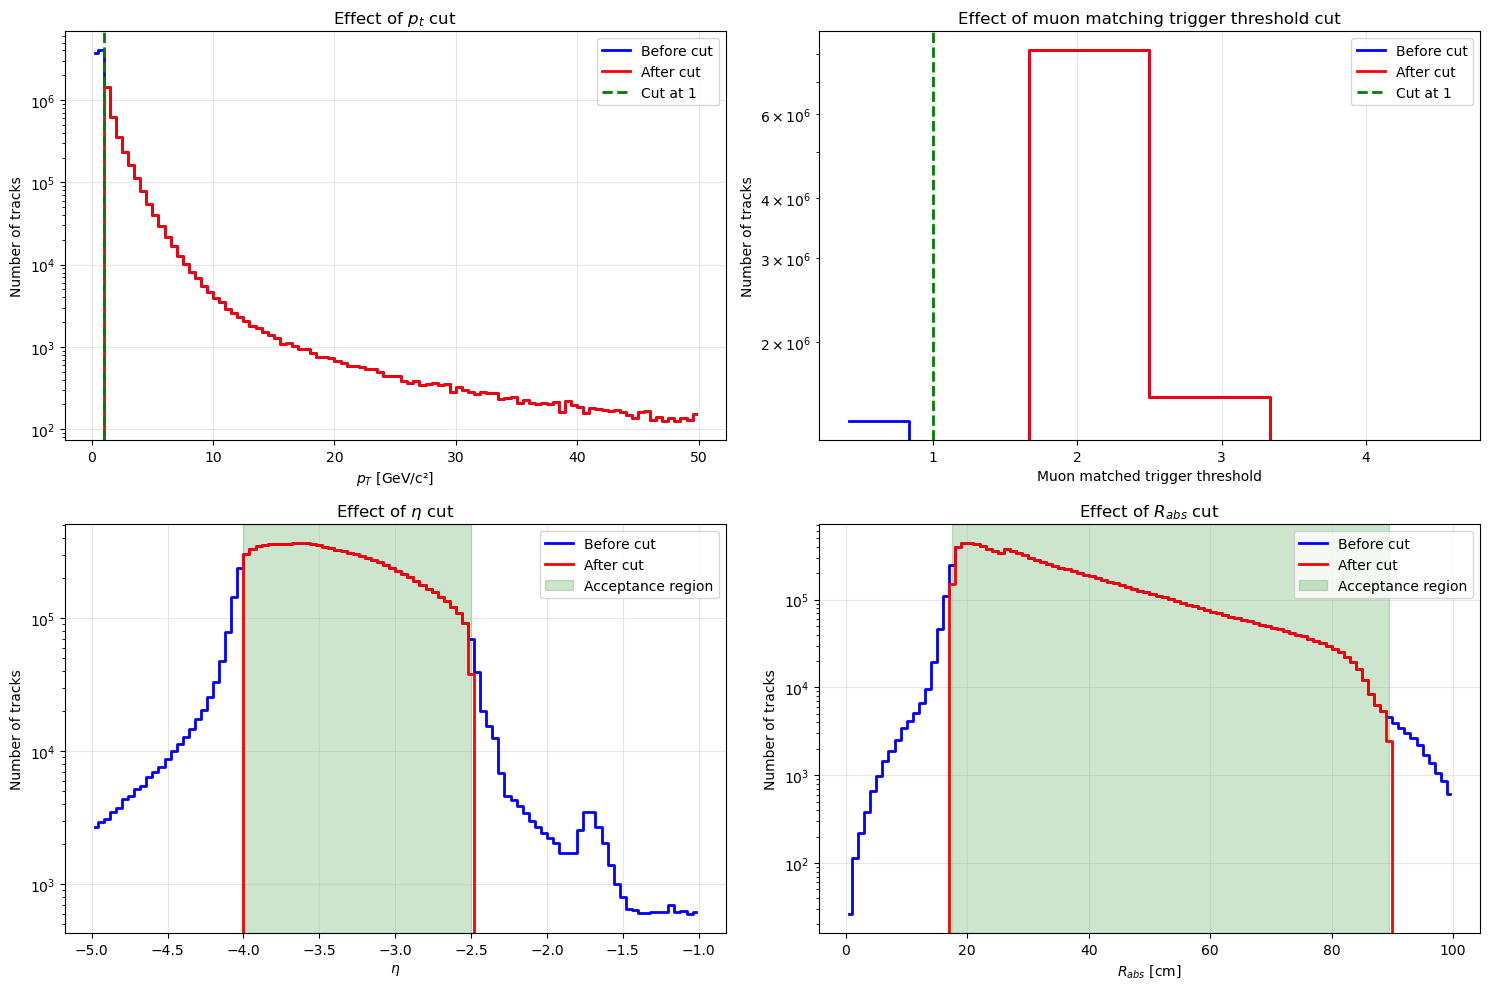

In [8]:
datasets = analyzeEventsTree2()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

plots_configs = [
    {"key": r"$p_t$", "bins": 100, "range": (0, 50), "xlabel": r"$p_T$ [GeV/c²]", "cut_line": 1},
    {"key": "muon matching trigger threshold", "bins": 6, "range": (0, 5), "xlabel": "Muon matched trigger threshold", "cut_line": 1},
    {"key": r"$\eta$", "bins": 100, "range": (-5, -1), "xlabel": r"$\eta$", "cut_region": (-4, -2.5)},
    {"key": r"$R_{abs}$", "bins": 100, "range": (0, 100), "xlabel": r"$R_{abs}$ [cm]", "cut_region": (17.5, 89.5)},
    #{"key": r"$p_{DCA}$", "bins": 100, "range": (0, 10), "xlabel": r"$p_{DCA}$", "cut_line": "dynamic"},
]

#tracer chaque plot seul
for i, config in enumerate(plots_configs):
    ax = axes[i]
    key = config["key"]

    h_raw = hist.Hist(hist.axis.Regular(config["bins"], *config["range"]))
    h_cut = hist.Hist(hist.axis.Regular(config["bins"], *config["range"]))
    
    h_raw.fill(datasets[key]["raw"])
    h_cut.fill(datasets[key]["cut"])
    
    ax.step(h_raw.axes[0].centers, h_raw.values(), where='mid', 
            color='blue', linewidth=2, label='Before cut')
    ax.step(h_cut.axes[0].centers, h_cut.values(), where='mid', 
            color='red', linewidth=2, label='After cut')
    
    if "cut_line" in config :
        ax.axvline(config["cut_line"], color='green', linestyle='--', 
                  linewidth=2, label=f'Cut at {config["cut_line"]}')
    
    if "cut_region" in config:
        ax.axvspan(config["cut_region"][0], config["cut_region"][1], 
                  alpha=0.2, color='green', label='Acceptance region')
    
    ax.set_xlabel(config["xlabel"])
    ax.set_ylabel("Number of tracks")
    ax.set_yscale("log")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_title(f"Effect of {key} cut")

plt.tight_layout()
plt.show()